<a href="https://colab.research.google.com/github/Neiluj35/Projet_recherche/blob/main/distribution_probas_chaque_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Grover circuit

Visualisation de la distribution des probabilités à chaque itération pour les différents cas



In [18]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-ibm-runtime
!pip install qiskit-aer

Importations


In [19]:

import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np
all_curves={}

Diffuseur

In [20]:
def diffuser(n=4,name='V'):#à vérifier
    qc = QuantumCircuit(n, name=name)
    qc.h(range(n))
    qc.x(n-1)
    qc.h(n-1)
    qc.mcx([0,1,2],3,ctrl_state='000')
    qc.h(n-1)
    qc.x(n-1)
    qc.h(range(n))
    return qc

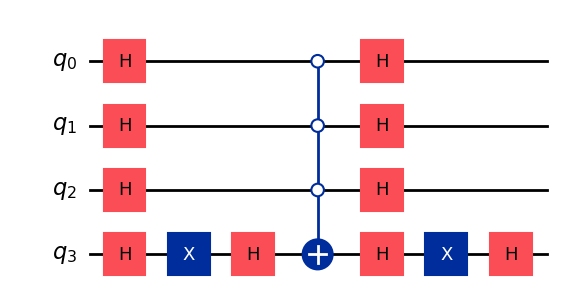

In [21]:
check = diffuser()
check.draw('mpl')

Oracle

In [22]:
def phase_oracle(n=4,name = 'Uf'):
    qc = QuantumCircuit(4, name=name)
    qc.x(n-1)
    qc.h(n-1)
    qc.mcx([0,1,2],3,ctrl_state='111') #mettre à 101 pour test ibm torino ou 111 pour le reste
    qc.h(n-1)
    qc.x(n-1)
    return qc

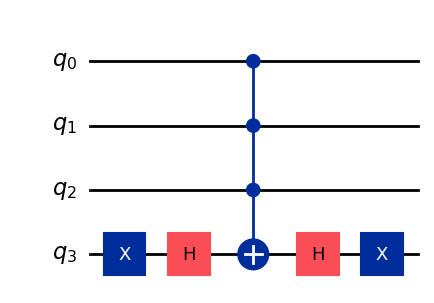

In [23]:
c = phase_oracle(4,'Yf')
c.draw('mpl')



## **Etat initial**

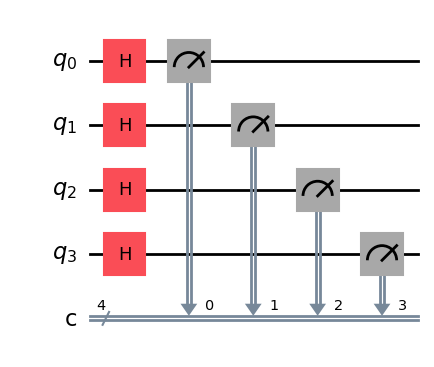

In [24]:
#Etat initial
n=4
gr0 = QuantumCircuit(n, n)
nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
r = round(np.pi/(4*alpha)-0.5) # Determine r

gr0.h(range(n))    # step 1: apply Hadamard gates on all working qubits

gr0.measure(range(n), range(n))    # step 3: measure all qubits

gr0.draw('mpl')

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


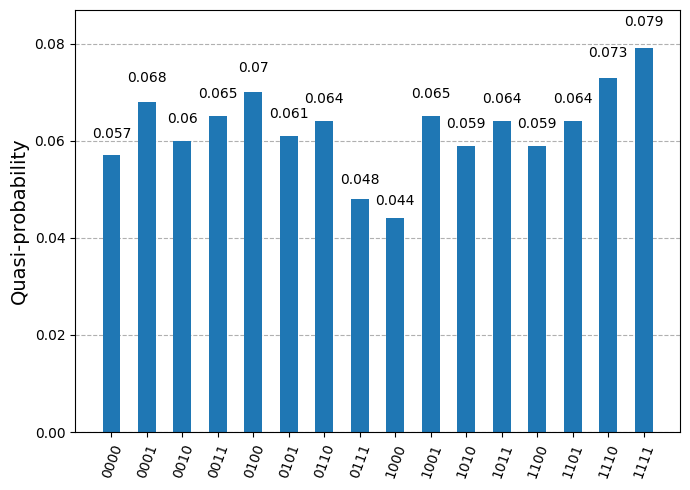

In [25]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gr0, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
counts0 = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(counts0)

## **Grover optimal**

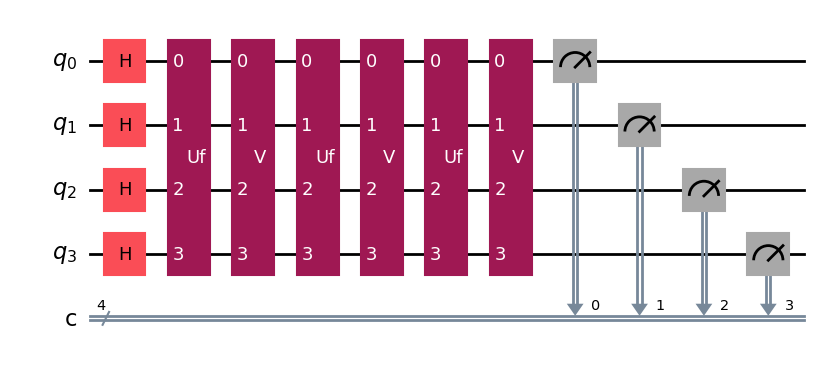

In [26]:

n=4
gr = QuantumCircuit(n, n)
nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
r = round(np.pi/(4*alpha)-0.5) # Determine r

gr.h(range(n))    # step 1: apply Hadamard gates on all working qubits


# step 2: apply r rounds of the phase oracle and the diffuser
for j in range(r):
    gr.append(phase_oracle(), range(n))
    gr.append(diffuser(), range(n))

gr.measure(range(n), range(n))    # step 3: measure all qubits

gr.draw('mpl')

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


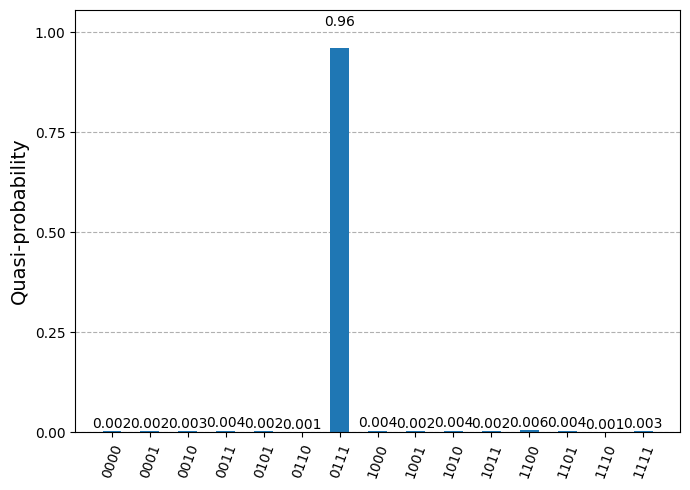

In [27]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gr, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
counts = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(counts)

---- Après 15 itération(s) ----
Probabilité de |0111⟩ = 1.000


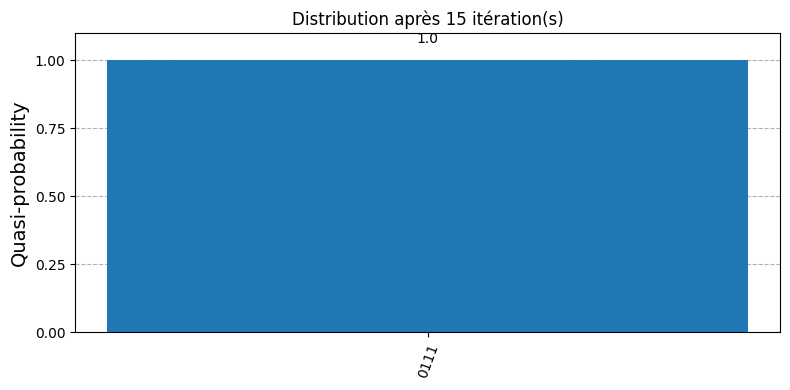

In [28]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

n = 4
max_r = 15
marked_state='0111'
all_counts = {}
all_prob = {}

for r in range(max_r + 1):
  test_r = QuantumCircuit(n, n)
  test_r.h(range(n))


  for _ in range(r):
    test_r.append(phase_oracle(), range(n))
    test_r.append(diffuser(), range(n))

  test_r.measure(range(n), range(n))

  simulator_aer=AerSimulator()
  test_r = transpile(test_r, simulator_aer)
  sampler_aer = Sampler(simulator_aer)
  job = sampler_aer.run([(test_r, None, 1000)])
  result = job.result()
  counts_test = result[0].data.c.get_counts()

  # Convertir en probabilité
  total = sum(counts_test.values())
  probs = {state: counts_test[state] / total for state in counts_test}

  all_counts[r] = counts_test
  all_prob[r] = probs

  clear_output(wait=True)
  print(f"---- Après {r} itération(s) ----")
  print(f"Probabilité de |{marked_state}⟩ = {probs.get(marked_state, 0):.3f}")

  fig = plot_histogram(
      probs,
      title=f"Distribution après {r} itération(s)",
      figsize=(8, 4)
  )
  display(fig)
  plt.close()

  time.sleep(1)

## **Grover non équi**

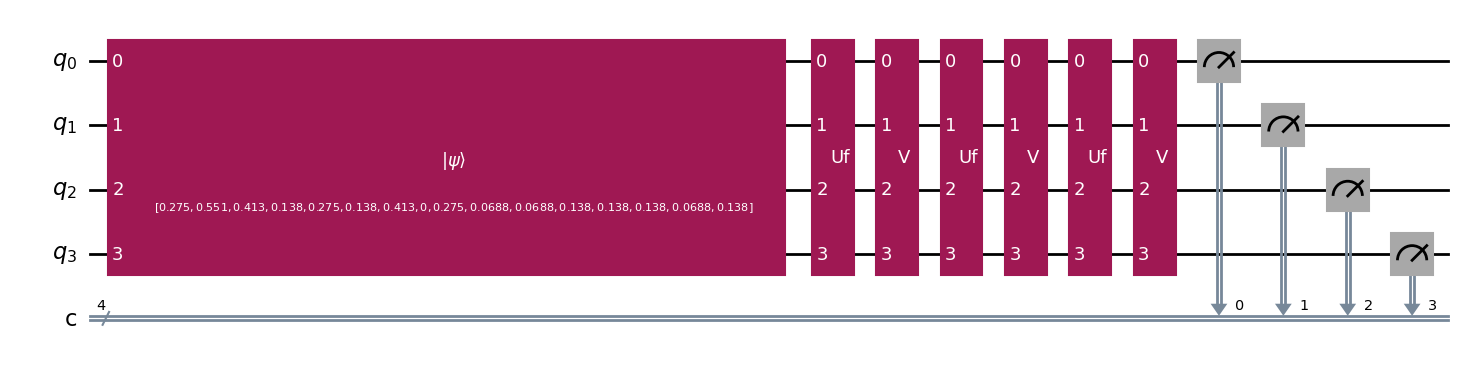

In [29]:
#Etat initial
import numpy as np
from qiskit import QuantumCircuit

n = 4
amplitudes = np.array([
    0.1, 0.2, 0.15, 0.05,
    0.1, 0.05, 0.15, 0,
    0.1, 0.025, 0.025, 0.05,
    0.05, 0.05, 0.025, 0.05
], dtype=complex)

amplitudes /= np.linalg.norm(amplitudes)

gr1 = QuantumCircuit(n, n)
gr1.initialize(amplitudes, range(n))

nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
r = round(np.pi/(4*alpha)-0.5) # Determine r

#gr1.h(range(n))    # step 1: apply Hadamard gates on all working qubits


# step 2: apply r rounds of the phase oracle and the diffuser
for j in range(r):
    gr1.append(phase_oracle(), range(n))
    gr1.append(diffuser(), range(n))

gr1.measure(range(n), range(n))    # step 3: measure all qubits

gr1.draw('mpl')

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


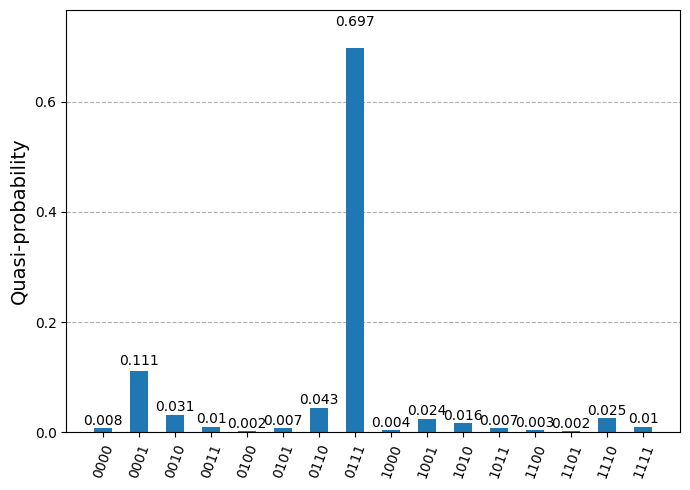

In [30]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gr1, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
counts1 = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(counts1)

---- Après 15 itération(s) ----
Probabilité de |0100⟩ = 0.000


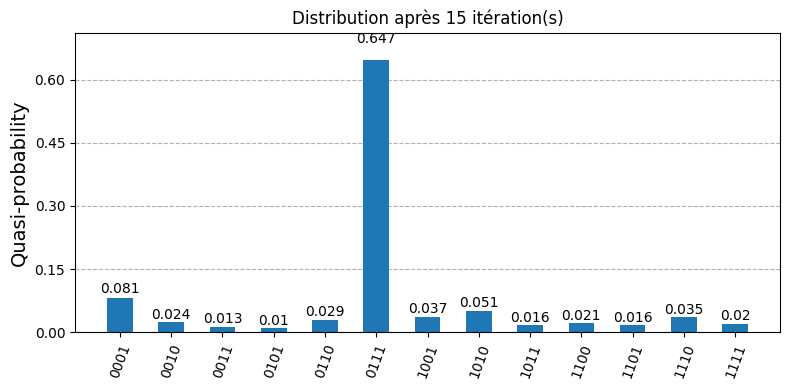

In [33]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

n = 4
max_r = 15
marked_state='0100'
amplitudes = np.array([
    0.1, 0.2, 0.15, 0.05,
    0.1, 0.05, 0.15, 0.01,
    0.1, 0.025, 0.025, 0.05,
    0.05, 0.05, 0.025, 0.05
], dtype=complex)
amplitudes /= np.linalg.norm(amplitudes)

all_counts = {}
all_prob = {}

for r in range(max_r + 1):
  test_r = QuantumCircuit(n, n)
  test_r.initialize(amplitudes, range(n))

  for _ in range(r):
    test_r.append(phase_oracle(), range(n))
    test_r.append(diffuser(), range(n))

  test_r.measure(range(n), range(n))

  simulator_aer=AerSimulator()
  test_r = transpile(test_r, simulator_aer)
  sampler_aer = Sampler(simulator_aer)
  job = sampler_aer.run([(test_r, None, 1000)])
  result = job.result()
  counts1_test = result[0].data.c.get_counts()

  # Convertir en probabilité
  total = sum(counts1_test.values())
  probs = {state: counts1_test[state] / total for state in counts1_test}

  all_counts[r] = counts1_test
  all_prob[r] = probs

  clear_output(wait=True)
  print(f"---- Après {r} itération(s) ----")
  print(f"Probabilité de |{marked_state}⟩ = {probs.get(marked_state, 0):.3f}")

  fig = plot_histogram(
      probs,
      title=f"Distribution après {r} itération(s)",
      figsize=(8, 4)
  )
  display(fig)
  plt.close()

  time.sleep(0.5)

## **Non équi2**

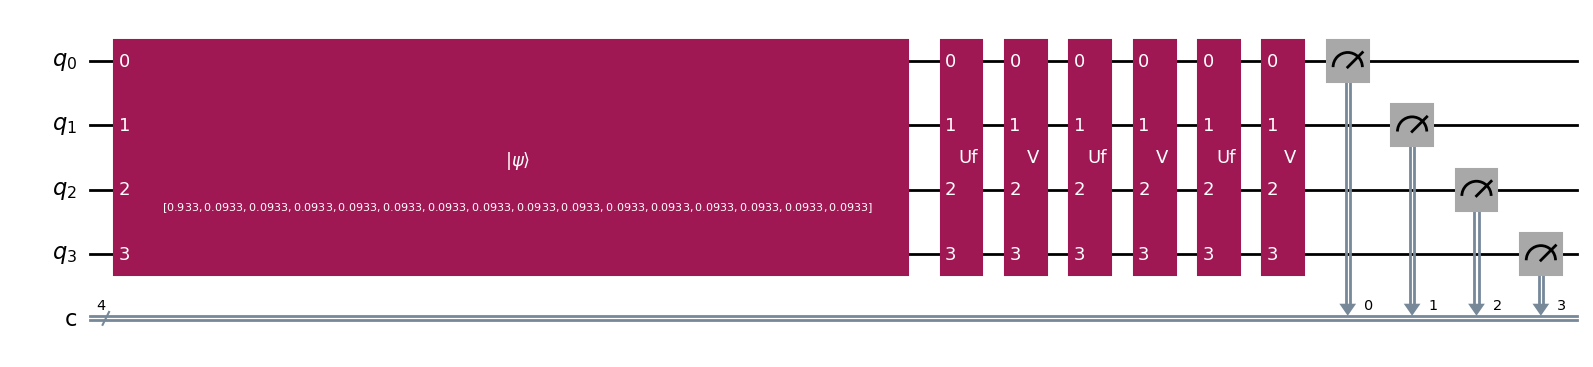

In [34]:
#Etat initial
import numpy as np
from qiskit import QuantumCircuit

n = 4
amplitudes = np.array([
    0.5, 0.05, 0.05, 0.05,
    0.05, 0.05, 0.05, 0.05,
    0.05, 0.05, 0.05, 0.05,
    0.05, 0.05, 0.05, 0.05
], dtype=complex)

amplitudes /= np.linalg.norm(amplitudes)

gr1v2 = QuantumCircuit(n, n)
gr1v2.initialize(amplitudes, range(n))

nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
r = round(np.pi/(4*alpha)-0.5) # Determine r

#gr1.h(range(n))    # step 1: apply Hadamard gates on all working qubits


# step 2: apply r rounds of the phase oracle and the diffuser
for j in range(r):
    gr1v2.append(phase_oracle(), range(n))
    gr1v2.append(diffuser(), range(n))

gr1v2.measure(range(n), range(n))    # step 3: measure all qubits

gr1v2.draw('mpl')

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


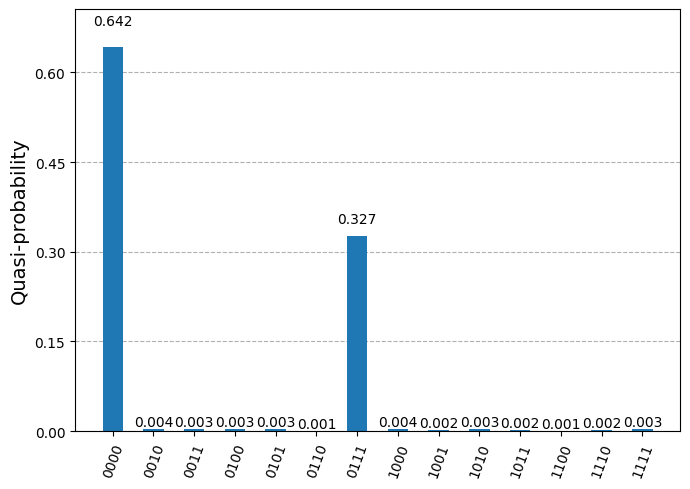

In [35]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gr1v2, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
counts1v2 = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(counts1v2)

---- Après 15 itération(s) ----
Probabilité de |0111⟩ = 0.547


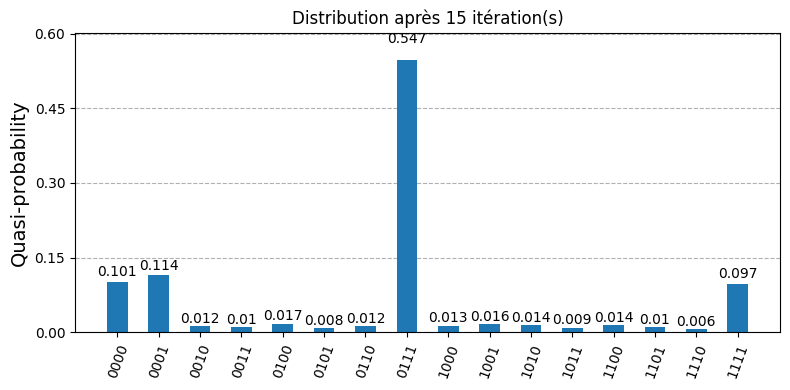

In [37]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time


n = 4
max_r = 15
marked_state='0111'
amplitudes = np.array([
    0.25, 0.25, 0.05, 0.05,
    0.05, 0.05, 0.05, 0.05,
    0.05, 0.05, 0.05, 0.05,
    0.05, 0.05, 0.05, 0.25
], dtype=complex)
amplitudes /= np.linalg.norm(amplitudes)

all_counts = {}
all_prob = {}

for r in range(max_r + 1):
  test_r = QuantumCircuit(n, n)
  test_r.initialize(amplitudes, range(n))

  for _ in range(r):
    test_r.append(phase_oracle(), range(n))
    test_r.append(diffuser(), range(n))

  test_r.measure(range(n), range(n))

  simulator_aer=AerSimulator()
  test_r = transpile(test_r, simulator_aer)
  sampler_aer = Sampler(simulator_aer)
  job = sampler_aer.run([(test_r, None, 1000)])
  result = job.result()
  counts1v2_test = result[0].data.c.get_counts()

  # Convertir en probabilité
  total = sum(counts1v2_test.values())
  probs = {state: counts1v2_test[state] / total for state in counts1v2_test}

  all_counts[r] = counts1v2_test
  all_prob[r] = probs

  clear_output(wait=True)
  print(f"---- Après {r} itération(s) ----")
  print(f"Probabilité de |{marked_state}⟩ = {probs.get(marked_state, 0):.3f}")

  fig = plot_histogram(
      probs,
      title=f"Distribution après {r} itération(s)",
      figsize=(8, 4)
  )
  display(fig)
  plt.close()

  time.sleep(0.5)

## **Non équi3**

3


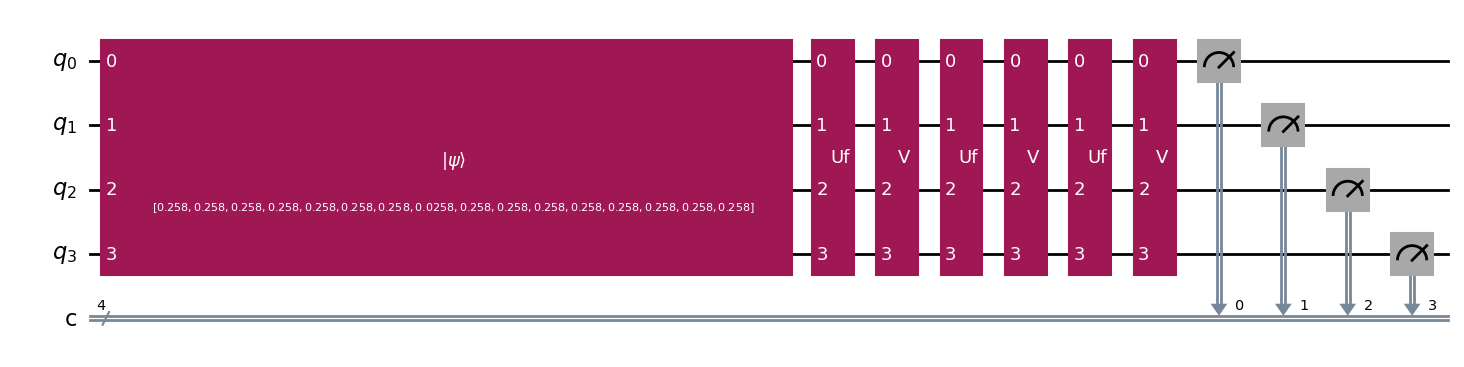

In [39]:
#Etat initial
import numpy as np
from qiskit import QuantumCircuit

n = 4
amplitudes = np.array([
    0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.05,
    0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.5
], dtype=complex)

amplitudes /= np.linalg.norm(amplitudes)

gr1v3 = QuantumCircuit(n, n)
gr1v3.initialize(amplitudes, range(n))

nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
r = round(np.pi/(4*alpha)-0.5) # Determine r
print(r)
#gr1.h(range(n))    # step 1: apply Hadamard gates on all working qubits


# step 2: apply r rounds of the phase oracle and the diffuser
for j in range(r):
    gr1v3.append(phase_oracle(), range(n))
    gr1v3.append(diffuser(), range(n))

gr1v3.measure(range(n), range(n))    # step 3: measure all qubits

gr1v3.draw('mpl')

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


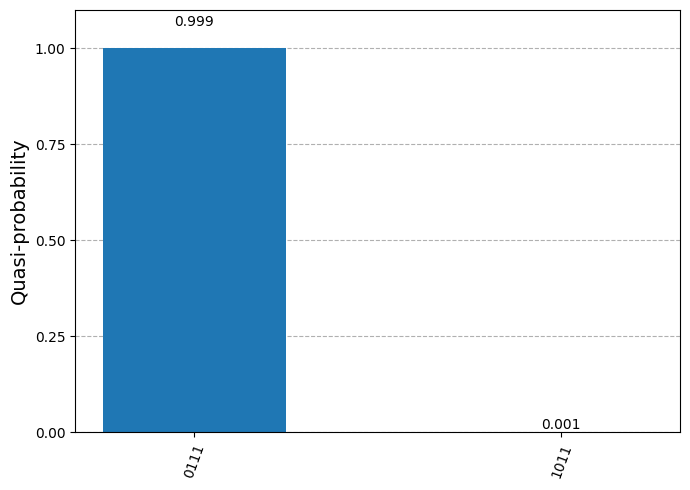

In [40]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gr1v3, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
counts1v3 = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(counts1v3)

---- Après 4 itération(s) ----
Probabilité de |0111⟩ = 0.782


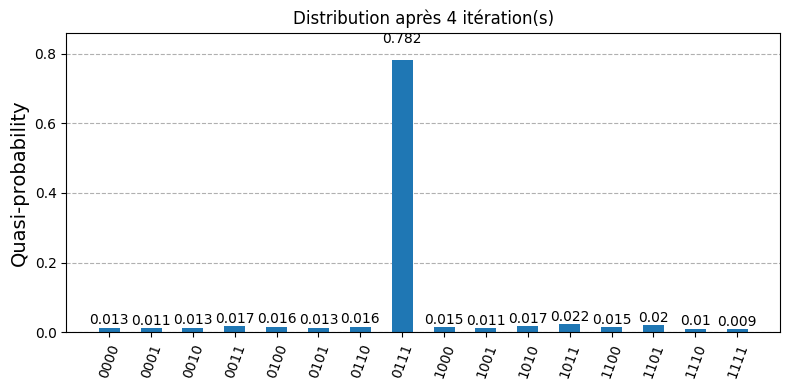

KeyboardInterrupt: 

In [42]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

n = 4
max_r = 15
marked_state='0111'
amplitudes = np.array([
    0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.05,
    0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.5
], dtype=complex)
amplitudes /= np.linalg.norm(amplitudes)

all_counts = {}
all_prob = {}

for r in range(max_r + 1):
  test_r = QuantumCircuit(n, n)
  test_r.initialize(amplitudes, range(n))

  for _ in range(r):
    test_r.append(phase_oracle(), range(n))
    test_r.append(diffuser(), range(n))

  test_r.measure(range(n), range(n))

  simulator_aer=AerSimulator()
  test_r = transpile(test_r, simulator_aer)
  sampler_aer = Sampler(simulator_aer)
  job = sampler_aer.run([(test_r, None, 1000)])
  result = job.result()
  counts1v3_test = result[0].data.c.get_counts()

 # Convertir en probabilité
  total = sum(counts1v3_test.values())
  probs = {state: counts1v3_test[state] / total for state in counts1v3_test}

  all_counts[r] = counts1v3_test
  all_prob[r] = probs

  clear_output(wait=True)
  print(f"---- Après {r} itération(s) ----")
  print(f"Probabilité de |{marked_state}⟩ = {probs.get(marked_state, 0):.3f}")

  fig = plot_histogram(
      probs,
      title=f"Distribution après {r} itération(s)",
      figsize=(8, 4)
  )
  display(fig)
  plt.close()

  time.sleep(0.5)

## Gauss

In [ ]:

import numpy as np
from qiskit import QuantumCircuit

n = 4
amplitudes = np.array([0.0, 0.000007, 0.000147, 0.001786,
                       0.013194, 0.05913,  0.160733, 0.265004,
                      0.265004, 0.160733, 0.05913,  0.013194,
                       0.001786, 0.000147, 0.000007, 0.0], dtype=complex)

amplitudes /= np.linalg.norm(amplitudes)

gauss = QuantumCircuit(n, n)
gauss.initialize(amplitudes, range(n))

nsol=1 #number of solutions
alpha=np.arcsin(np.sqrt(nsol/2**(n))) # Determine alpha
r = round(np.pi/(4*alpha)-0.5) # Determine r

# step 2: apply r rounds of the phase oracle and the diffuser
for j in range(r):
    gauss.append(phase_oracle(), range(n))
    gauss.append(diffuser(), range(n))

gauss.measure(range(n), range(n))    # step 3: measure all qubits

gauss.draw('mpl')

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit import transpile
simulator_aer=AerSimulator()
gr_trsp = transpile(gauss, simulator_aer)
sampler_aer = Sampler(simulator_aer)
job = sampler_aer.run([(gr_trsp, None,1000)])
result =  job.result()
print(result)
countsgauss = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution(countsgauss)

In [ ]:
import numpy as np
from qiskit import QuantumCircuit

n = 4
max_r = 15
marked_state='0111'
amplitudes = np.array([0.0, 0.000007, 0.000147, 0.001786,
                       0.013194, 0.05913,  0.160733, 0.265004,
                      0.265004, 0.160733, 0.05913,  0.013194,
                       0.001786, 0.000147, 0.000007, 0.0], dtype=complex)
amplitudes /= np.linalg.norm(amplitudes)

probas = []

for r in range(max_r + 1):
  test_r = QuantumCircuit(n, n)
  test_r.initialize(amplitudes, range(n))

  for _ in range(r):
    test_r.append(phase_oracle(), range(n))
    test_r.append(diffuser(), range(n))

  test_r.measure(range(n), range(n))

  simulator_aer=AerSimulator()
  test_r = transpile(test_r, simulator_aer)
  sampler_aer = Sampler(simulator_aer)
  job = sampler_aer.run([(test_r, None, 1000)])
  result = job.result()
  countsgauss_test = result[0].data.c.get_counts()

  p = countsgauss_test.get(marked_state, 0) / 1000
  probas.append(p)
  all_curves['Grover gauss']=probas

# Tracé
plt.plot(range(max_r + 1), probas, marker='o')
plt.xlabel("Nombre d'itérations Grover (r)")
plt.ylabel(f"Probabilité d'obtenir {marked_state}")
plt.title("Évolution de la probabilité en fonction de r")
plt.grid(True)
plt.show()

# Afficher l’itération optimale
opt = np.argmax(probas)
print(f"Iteration optimale : r = {opt} avec p = {probas[opt]:.4f}")


## Résultats

In [ ]:
plot_distribution([counts,counts0,counts1, countsgauss], legend = ['Grover optimal', 'Initial','Grover non-équi','Grover gauss'])

In [ ]:
plt.figure(figsize=(8,5))

for label, probas in all_curves.items():
    plt.plot(range(max_r + 1), probas, marker='o', label=label)

plt.xlabel("Nombre d'itérations Grover (r)")
plt.ylabel("Probabilité de l'état marqué")
plt.title("Comparaison des probabilités en fonction de r")
plt.grid(True)
plt.legend()
plt.show()

## IBM

In [ ]:
# PUBs on IBM quantum computers
from qiskit_ibm_runtime import QiskitRuntimeService
token = "nDLD07y8TqS3jvE-zdQ3RFLExYFd4E89wPIw4qV_tclN"
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum_platform", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/2f903a94d6564bb2a042b9d46bda122d:6c4b797f-5ec9-4077-b5fa-bf87972e20d0::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
  name="Faryad-free-ibm", # Optionally name this set of credentials.
  overwrite=True # Only needed if you already have Cloud credentials.
)

In [ ]:
# @title
# Load saved credentials if you specified a name
ibm_service = QiskitRuntimeService(name="Faryad-free-ibm")
ibmq_comp = ibm_service.backend('ibm_torino')

from qiskit_ibm_runtime import SamplerV2
sampler_ibm = SamplerV2(mode=ibmq_comp)

qc_tr_ibm = transpile(gr, backend = ibmq_comp)

job_ibm = sampler_ibm.run([(qc_tr_ibm,None,1000)]) #PUB = (circuit, paramters, shots)
print(job_ibm.job_id())

In [ ]:

job = ibm_service.job('d1l10an29o4s73ap5gjg')
result = job.result()
counts_ibm = result[0].data.c.get_counts()
from qiskit.visualization import plot_histogram, plot_distribution

plot_distribution([counts,counts_ibm], legend = ['Simulator', 'IBM Torino'])

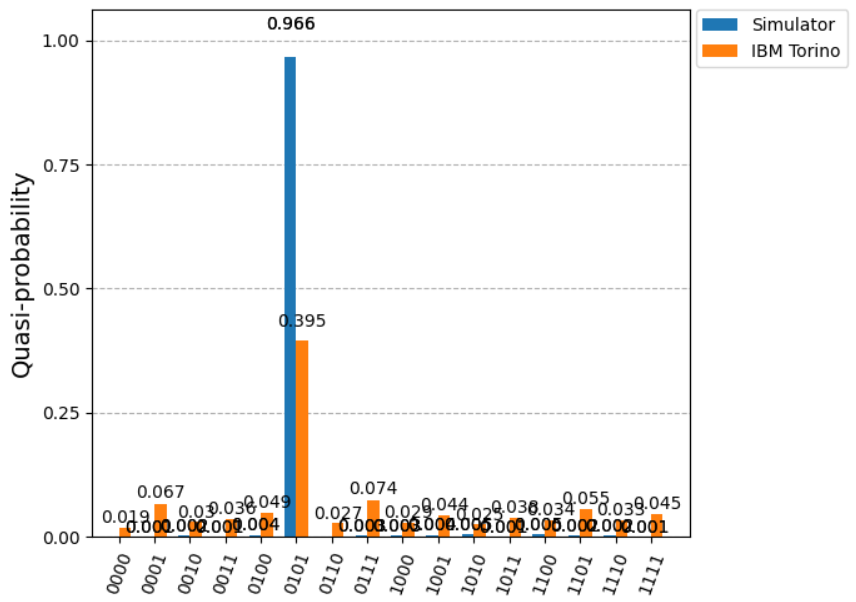